In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import auditory_cortex.models as Reg
from auditory_cortex import pretrained_dir
# %matplotlib inline
# import auditory_cortex.helpers as helpers
# from transformers import Speech2TextForConditionalGeneration, Speech2TextProcessor

INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.


### wave2vec (fairseq)

In [2]:
import torch
import fairseq

INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX


In [6]:
cp_path = os.path.join(pretrained_dir, 'wave2vec', 'wav2vec_large.pt')
model, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([cp_path])
model = model[0]
model.eval()

wav_input_16khz = torch.randn(1,16000)
z = model.feature_extractor(wav_input_16khz)
c = model.feature_aggregator(z)

DEBUG:hydra.core.utils:Setting JobRuntime:name=utils


DEBUG:hydra.core.utils:Setting JobRuntime:name=utils
INFO:fairseq.models.wav2vec.wav2vec:Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2-4): 3 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (5-6): 2 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, in

In [22]:
wav_input_16khz.shape

torch.Size([1, 16000])

In [36]:
dict([*model.named_modules()])['feature_extractor.conv_layers.0.3']

ReLU()

In [3]:
# model_name = 'wave2letter_modified'
model_name = 'wave2vec'
# model = 'deepspeech2'
obj = Reg.Regression(
            model_name, load_features=True,
            delay_features = False, audio_zeropad = False
        )

Loading Neural data for session: 180810 ... 

DEBUG:hydra.core.utils:Setting JobRuntime:name=utils


Done.
Creating regression obj for: 'wave2vec'


DEBUG:hydra.core.utils:Setting JobRuntime:name=utils
INFO:fairseq.models.wav2vec.wav2vec:Wav2VecModel(
  (feature_extractor): ConvFeatureExtractionModel(
    (conv_layers): ModuleList(
      (0): Sequential(
        (0): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (1): Sequential(
        (0): Conv1d(512, 512, kernel_size=(8,), stride=(4,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (2-4): 3 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(4,), stride=(2,), bias=False)
        (1): Dropout(p=0.0, inplace=False)
        (2): Fp32GroupNorm(1, 512, eps=1e-05, affine=True)
        (3): ReLU()
      )
      (5-6): 2 x Sequential(
        (0): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
        (1): Dropout(p=0.0, in

Loading ANN features at bin-width: 20


In [11]:
aud = obj.dataset.audio(sent=12)

In [16]:
aud_tensor = torch.tensor(aud, dtype=torch.float32)

In [23]:
aud_tensor = aud_tensor.unsqueeze(dim=0)

In [24]:
z = model.feature_extractor(aud_tensor)
c = model.feature_aggregator(z)

### Error testing part..can be removed afterwards....

### Re-sampling method: 

In [2]:
model = 'wave2letter_modified'
# model = 'deepspeech2'
obj = Reg.Regression(model, 
                                load_features=False,
                                delay_features = False,
                                audio_zeropad = False)

Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'wave2letter_modified'
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/results/pretrained_weights/wave2letter_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt


In [3]:
raw_features = obj.extract_features()

In [34]:
sampled_features = obj.resample(raw_features, bin_width=20)


In [35]:
layer = 2
sent = 12
y1 = raw_features[layer][sent][:,0]
x1 = np.linspace(0, 1, num=y1.shape[0])

y2 = sampled_features[layer][sent][:,0]
x2 = np.linspace(0, 1, num=y2.shape[0])

In [36]:
print(y1.shape)

torch.Size([274])


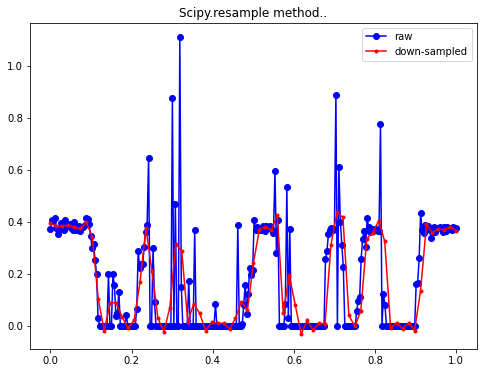

In [38]:
plt.figure(figsize=(8,6))
plt.plot(x1, y1, 'bo-', x2, y2, 'r.-' )
plt.legend(['raw', 'down-sampled'], loc='best')
plt.title(f"Scipy.resample method..")
plt.show()

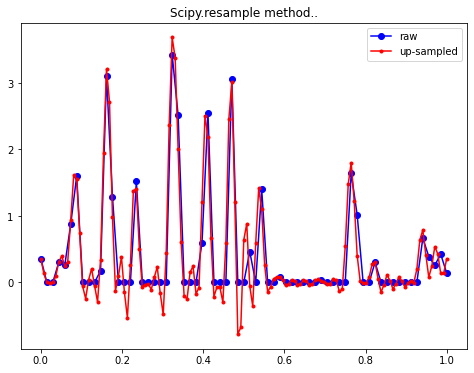

In [33]:
plt.figure(figsize=(8,6))
plt.plot(x1, y1, 'bo-', x2, y2, 'r.-' )
plt.legend(['raw', 'up-sampled'], loc='best')
plt.title(f"Scipy.resample method..")
plt.show()

### Visualizing filters of pre-trained networks...

In [40]:
from wav2letter.models import Wav2LetterRF
import torch

checkpoint = '/depot/jgmakin/data/auditory_cortex/pretrained_weights/w2l_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt'
model = Wav2LetterRF.load_from_checkpoint(checkpoint)

In [41]:
modules = dict([*model.named_modules()])

In [42]:
layer_ids = [6,5,4,3,2]
kernels = {}
for layer_id in layer_ids:

    kernel = modules[f'conv{layer_id}.conv'].weight
    out = torch.absolute(kernel)/(torch.norm(kernel, p=1, dim=2)[:,:,None])
    kernels[layer_id] = out.view(-1,3).mean(dim=0).detach().numpy()

In [43]:
weights_product = []
for weight6 in kernels[6]:
    product = 1*weight6
    for weight5 in kernels[5]:
        product *= weight5
        for weight4 in kernels[4]:
            product *= weight4
            for weight3 in kernels[3]:
                product *= weight3
                for weight2 in kernels[2]:
                    product *= weight2
                    weights_product.append(product)

In [71]:
weights_product3 = []
for weight6 in kernels[6]:
    product = 1*weight6
    for weight5 in kernels[5]:
        product *= weight5
        for weight4 in kernels[4]:
            product *= weight4
            for weight3 in kernels[3]:
                product *= weight3
                weights_product3.append(product)

In [44]:
len(weights_product)

243

In [50]:
np.sum(weights_product)

0.01586505299748707

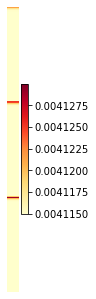

In [70]:
plt.figure()
ax2 = plt.axes([0,0,0.1,0.99])

weights_product = np.array(weights_product)
data = np.exp(weights_product[:,None])/np.sum(np.exp(weights_product))
vmin = data.min()
vmax = data.max()
cax = ax2.imshow(np.atleast_2d(data),extent= [0, 10, 0, data.shape[0]],vmin=vmin, vmax=vmax,
           cmap='YlOrRd')
plt.axis('off')
plt.colorbar(cax)

In [63]:
data.shape

(243, 1)

In [56]:
np.atleast_2d(data).shape

(1, 243)

In [101]:
weights_product[120:150]

[2.449728261015618e-30,
 8.69654163446134e-31,
 2.8909001493139176e-31,
 2.838128365646438e-32,
 1.0075363006000204e-32,
 3.349247280438279e-33,
 1.0776957249919245e-34,
 3.8258225987023133e-35,
 1.2717780914208355e-35,
 1.4579048702534677e-36,
 5.175566043389173e-37,
 1.7204591522138492e-37,
 1.6890531217389084e-38,
 5.996142931350894e-39,
 1.9932349230480704e-39,
 2.0949750678919939e-41,
 7.43716688541115e-42,
 2.4722594064645474e-42,
 2.8340785656936826e-43,
 1.0060986205740008e-43,
 3.3444681514734775e-44,
 3.283416734732495e-45,
 1.1656137862837924e-45,
 3.874727691128787e-46,
 1.359624045430206e-47,
 4.8266688622012675e-48,
 1.604478920578496e-48,
 1.8392970033923745e-49,
 6.529509098086773e-50,
 2.170536245328378e-50]

In [98]:
weights_product

[0.0035691930250554083,
 0.0012670644429335538,
 0.0004211969471579317,
 4.828398010154469e-05,
 1.7140825368790128e-05,
 5.697944849897613e-06,
 5.593932017410339e-07,
 1.9858473065737793e-07,
 6.601343978323134e-08,
 2.3163811035374538e-09,
 8.223158882055508e-10,
 2.7335384845126176e-10,
 3.1335962590328185e-11,
 1.1124274788328235e-11,
 3.697926026036793e-12,
 3.6304224312444695e-13,
 1.288800897896757e-13,
 4.2842256896714317e-14,
 1.3785460803763924e-15,
 4.893842134982968e-16,
 1.6268086273144484e-16,
 1.8648946987932338e-17,
 6.620380982671858e-18,
 2.2007438330980342e-18,
 2.160570471352783e-19,
 7.670030736599912e-20,
 2.549667894857658e-20,
 2.898536312484775e-22,
 1.0289811372821969e-22,
 3.420534102455956e-23,
 3.9211347958253665e-24,
 1.3920038621791025e-24,
 4.627292482649479e-25,
 4.542823817096128e-26,
 1.612703624810213e-26,
 5.360941562434908e-27,
 1.88112962650784e-28,
 6.67801501786236e-29,
 2.2199025111037317e-29,
 2.5447888308960465e-30,
 9.034006902310287e-31,
 

In [73]:
kernel_6 = model['conv6.conv'].weight

TypeError: 'Wav2LetterRF' object is not subscriptable

In [6]:
kernel_6.shape

torch.Size([250, 250, 3])

In [35]:
import torch
p = np.random.randint(0, 250)
q = np.random.randint(0, 250)
print(p,1)
select = kernel_6[p,q,...]
frac = torch.norm(select[2], p=1)/torch.norm(kernel_6[p,q,...], p=1)
print(frac)

72 1
tensor(0.0103, grad_fn=<DivBackward0>)


In [39]:
torch.norm(kernel_6, p=1, dim=2).shape

torch.Size([250, 250])

In [67]:
index = 2
out = torch.absolute(kernel_6)/(torch.norm(kernel_6, p=1, dim=2)[:,:,None])
# torch.mean(out)

tensor([0.3359, 0.3234, 0.3407], grad_fn=<MeanBackward1>)

In [66]:
torch.absolute(kernel_6).shape

torch.Size([250, 250, 3])

In [24]:
import torch
torch.norm(kernel_6[p,q,...], p=1)

tensor(0.1164, grad_fn=<NormBackward1>)

### Starting pretrained networks study...

In [2]:
model = 'wave2letter_modified'
obj = Reg.Regression(model, 
                                load_features=True,
                                delay_features = True,
                                audio_zeropad = True)
# obj.load_features(delay_features=False)
# aud = obj.dataset.audio(sent=12)

Loading Neural data for session: 180810 ... Done.
Creating regression obj for: 'wave2letter_modified'
Loading from checkpoint: /depot/jgmakin/data/auditory_cortex/pretrained_weights/w2l_modified/Wav2letter-epoch=024-val_loss=0.37.ckpt
Loading ANN features at bin-width: 20
Features Delay requested:
- Delaying features by half of RF for each layer
Layer-wise delays (in samples) will be: [0 0 0 0 1 2 3 4] 
 - spikes trimming not needed. 
                    (Zero-paddading audio by 80ms, before extracting features)


In [3]:
layer = 7
sent = 12
obj.sampled_features[layer][sent].shape

(69, 250)

In [4]:
spikes = obj.get_neural_spikes(200206, sents=[12])
spikes.shape

Loading Neural data for session: 200206 ... Done.


(69, 64)

In [5]:
obj.sampled_features[layer][sent][:20, 0]

array([ 1.1219698e-08,  8.4306404e-02,  2.5096351e-01,  2.0520541e-01,
       -4.4878792e-08,  0.0000000e+00, -4.4878792e-08,  7.1542762e-02,
        3.2788628e-01,  6.5547627e-01,  3.5279036e-01,  1.4689782e-01,
        3.4357452e-01,  1.6829548e-08,  3.9268944e-08,  5.6098490e-09,
        1.4403344e-03,  4.8372239e-01,  2.2439396e-08, -1.1219698e-08],
      dtype=float32)

In [5]:
aud = obj.dataset.audio(sent=12)

In [41]:
bin_width = 20
layer_delays = (np.array(obj.receptive_fields)/(2.0*bin_width)).astype(int)
max_layer_delay = np.max(layer_delays)

# max_layer_delay = 4
audio_padding_samples = (max_layer_delay * bin_width)*16 # sampling rate/1000

In [42]:
sent = 12
layer = 7
audio_zeropad = True
if audio_zeropad:
    audio_input = np.concatenate([
            np.zeros(audio_padding_samples),
            obj.dataset.audio(sent)
        ], axis=0)
else:
    audio_input = obj.dataset.audio(sent)

obj.model_extractor.translate(audio_input, grad = False)
feats = obj.model_extractor.get_features(layer)

In [43]:
feats.shape

torch.Size([85, 250])

In [22]:
max_layer_delay = 4

In [24]:
audio_padding_samples

1280

In [27]:
np.concatenate([np.zeros(audio_padding_samples), obj.dataset.audio(sent)], axis=0).shape

(23194,)

In [28]:
obj.dataset.audio(sent).shape

(21914,)

In [11]:
import time
start_time = time.time()
delays = [0, 10, 20, 30]   

corr_coeffs, losses, delays = obj.grid_search_CV(session=200206)

current_time = time.time()
print(f"It took {current_time-start_time} sec to run...!")

Loading Neural data for session: 200206 ... Done.
# of iterations requested: 1, 
# of lambda samples per iteration: 10
Itr: 1:
K_fold for session: 200206
It takes (on avg.) 3.76 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.84 sec/mapping.
It takes (on avg.) 0.11 minutes/iteration...!
# of iterations requested: 1, 
# of lambda samples per iteration: 10
Itr: 1:
K_fold for session: 200206
It takes (on avg.) 2.66 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.76 sec/mapping.
It takes (on avg.) 0.09 minutes/iteration...!
# of iterations requested: 1, 
# of lambda samples per iteration: 10
Itr: 1:
K_fold for session: 200206
It takes (on avg.) 2.65 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.77 sec/mapping.
It takes (on avg.) 0.09 minutes/iteration...!
# of iterations requested: 1, 
# of lambda samples per iteration: 10
Itr: 1:
K_fold for session: 200206
It takes (on avg.) 2.74 sec (all lmbdas). (time for 5-folds)
It takes (on avg.) 2.79 sec/mapping.
It t

In [12]:
num_layers = 10
num_channels = 64

opt_indices = np.argmin(losses, axis=0)
outputs = corr_coeffs[opt_indices, np.arange(num_layers)[:, None], np.arange(num_channels)]

In [28]:
layer = 6
ch = 10

opt_delays = delays[np.argmin(losses, axis=0)]

print(f"Corr: {outputs[layer, ch]:.4f}")
print(f"Opt delay: {opt_delays[layer, ch]}")
print(f"Losses: {losses[:,layer,ch]}")
print(f"All corrs: {corr_coeffs[:, layer,ch]}")


Corr: 0.4436
Opt delay: 20
Losses: [0.9994372  0.98759841 0.94704945 0.98317092]
All corrs: [0.41214668 0.43030319 0.44361376 0.45793271]


In [30]:
layer = 9
ch = 10

opt_delays = delays[np.argmin(losses, axis=0)]

print(f"Corr: {outputs[layer, ch]:.4f}")
print(f"Opt delay: {opt_delays[layer, ch]}")
print(f"Losses: {losses[:,layer,ch]}")
print(f"All corrs: {corr_coeffs[:, layer,ch]}")

Corr: 0.3964
Opt delay: 20
Losses: [1.0258385  1.02811073 0.99412542 1.0440326 ]
All corrs: [0.38196971 0.39285874 0.39642942 0.4135195 ]


In [31]:
layer = 8
ch = 17

opt_delays = delays[np.argmin(losses, axis=0)]

print(f"Corr: {outputs[layer, ch]:.4f}")
print(f"Opt delay: {opt_delays[layer, ch]}")
print(f"Losses: {losses[:,layer,ch]}")
print(f"All corrs: {corr_coeffs[:, layer,ch]}")

Corr: 0.4771
Opt delay: 0
Losses: [3.82472182 4.05805608 3.949644   4.05897682]
All corrs: [0.47710547 0.48277467 0.48485726 0.49196081]


In [32]:
layer = 4
ch = 40

opt_delays = delays[np.argmin(losses, axis=0)]

print(f"Corr: {outputs[layer, ch]:.4f}")
print(f"Opt delay: {opt_delays[layer, ch]}")
print(f"Losses: {losses[:,layer,ch]}")
print(f"All corrs: {corr_coeffs[:, layer,ch]}")

Corr: 0.2425
Opt delay: 0
Losses: [1.15563414 1.17476328 1.17275243 1.16324869]
All corrs: [0.24254437 0.22199906 0.22651176 0.22276289]


In [17]:
corr_coeffs[:, 6,32]

array([0.63412442, 0.64467001, 0.62696613, 0.62443238])

In [18]:
losses[:,6,32]

array([2.44284972, 2.51773814, 2.45157232, 2.53885695])

In [8]:
np.arange(10)[:,np.newaxis].shape

(10, 1)

In [7]:
a[np.newaxis, ... , np.newaxis, np.newaxis].shape

(1, 4, 5, 1, 1)

In [12]:
delays

array([ 0, 10, 20, 30])

In [13]:
opt_delays = delays[np.argmin(losses, axis=0)]

In [18]:
opt_indices.shape

(10, 64)

In [19]:
corr_reported = corr_coeffs[opt_indices]

In [20]:
corr_reported.shape

(10, 64, 10, 64)

In [5]:
layer = 7
sent = 12
obj.sampled_features[layer][sent].shape

(59, 250)

In [4]:
session = 200206
spikes = obj.get_neural_spikes(session, sents=[12])

Loading Neural data for session: 200206 ... Done.


In [5]:
spikes.shape

(53, 64)

In [7]:
tmp = obj.sampled_features[layer][sent]
tmp.shape

(66, 250)

In [9]:
delays = np.array([0, 0, 0, 0, 1, 2, 3, 4, 7, 10, 13])
max_delay = np.max(delays)

In [12]:
layer = 0
s = tmp.shape[0]
tmp[max_delay-delays[layer] : s-delays[layer]].shape

(53, 250)

In [15]:
layer = 1
sent = 12
obj.sampled_features[layer][sent].shape

(69, 250)

In [3]:
# features = obj.unroll_features(sents=[12])

In [7]:
# features.shape

(12, 69, 250)

In [10]:
a = np.array([1.0, 2.0, 3.9, 4.0])

In [11]:
a.astype(int)

array([1, 2, 3, 4])

In [5]:
session = '200206'
bin_width = 20
delay = 0
iterations = 5
k_folds_validation = 5
N_sents = 500
use_cpu = False
corr_dict = obj.cross_validated_regression(session, bin_width=bin_width, delay=delay,
                            N=iterations, k=k_folds_validation, N_sents=N_sents,
                            return_dict=True, numpy=use_cpu)

# of iterations requested: 5, 
# of lambda samples per iteration: 20
Itr: 1:
K_fold for session: 200206
Itr: 2:
K_fold for session: 200206


KeyboardInterrupt: 

In [6]:
from IPython.display import Audio
Audio(data=aud, rate=16000)

### pretrained 'whisper'

In [2]:
import torch
from transformers import AutoProcessor, WhisperForConditionalGeneration
# from datasets import load_dataset

processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

In [10]:
aud = obj.dataset.audio(sent=32)
inputs = processor(aud, return_tensors="pt", sampling_rate=16000)
input_features = inputs.input_features

generated_ids = model.generate(inputs=input_features, max_new_tokens=400)

transcription = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
transcription


' He moistened his lips uneasily.'

#### Network and hidden layers.
Whisper is transformer based network, with encoder having following architecture;
- 02 convolution layers
- 04 self attention layers  
Decoder also has 04 layers of attention.

In [28]:
dict([*model.named_modules()])['model.encoder']

WhisperEncoder(
  (conv1): Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(384, 384, kernel_size=(3,), stride=(2,), padding=(1,))
  (embed_positions): Embedding(1500, 384)
  (layers): ModuleList(
    (0): WhisperEncoderLayer(
      (self_attn): WhisperAttention(
        (k_proj): Linear(in_features=384, out_features=384, bias=False)
        (v_proj): Linear(in_features=384, out_features=384, bias=True)
        (q_proj): Linear(in_features=384, out_features=384, bias=True)
        (out_proj): Linear(in_features=384, out_features=384, bias=True)
      )
      (self_attn_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (activation_fn): GELUActivation()
      (fc1): Linear(in_features=384, out_features=1536, bias=True)
      (fc2): Linear(in_features=1536, out_features=384, bias=True)
      (final_layer_norm): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (1): WhisperEncoderLayer(
      (self_attn): WhisperAttention(


In [27]:
dict([*model.named_modules()])['model.encoder.conv1']


Conv1d(80, 384, kernel_size=(3,), stride=(1,), padding=(1,))

In [25]:
dict([*model.named_modules()])['model.encoder.layers.0.final_layer_norm']

LayerNorm((384,), eps=1e-05, elementwise_affine=True)

### pretrained 'speech2text'

In [8]:
model = Speech2TextForConditionalGeneration.from_pretrained("facebook/s2t-large-librispeech-asr")
processor = Speech2TextProcessor.from_pretrained("facebook/s2t-large-librispeech-asr")
# model.encoder.layers.0.final_layer_norm

In [17]:
dict([*model.named_modules()])['model']

Speech2TextModel(
  (encoder): Speech2TextEncoder(
    (conv): Conv1dSubsampler(
      (conv_layers): ModuleList(
        (0): Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))
        (1): Conv1d(512, 2048, kernel_size=(5,), stride=(2,), padding=(2,))
      )
    )
    (embed_positions): Speech2TextSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): Speech2TextEncoderLayer(
        (self_attn): Speech2TextAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_featu

In [9]:
dict([*model.named_modules()])['model.encoder.conv.conv_layers.0']

Conv1d(80, 1024, kernel_size=(5,), stride=(2,), padding=(2,))

In [15]:
dict([*model.named_modules()])['model.encoder.layers.0.final_layer_norm']
# 

LayerNorm((1024,), eps=1e-05, elementwise_affine=True)

### pretrained 'wave2vec2'

In [5]:
obj = Reg.Regression(load_features=False)
audio = obj.dataset.audio(sent=12)

Loading Neural data for session: 180810 ... 

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/s2t-large-librispeech-asr/resolve/main/config.json HTTP/1.1" 200 0


Done.
Creating regression obj for: 'speech2text'


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/s2t-large-librispeech-asr/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/s2t-large-librispeech-asr/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/s2t-large-librispeech-asr/resolve/main/vocab.json HTTP/1.1" 200 0


In [3]:
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2FeatureExtractor, Wav2Vec2ForCTC
import torch

# load model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
# model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-base-960h")

# inputs = feature_extractor(audio, sampling_rate=16000, return_tensors="pt").input_values
# outputs = processor(inputs, output_hidden_states=True)



DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/wav2vec2-base-960h/resolve/main/preprocessor_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/wav2vec2-base-960h/resolve/main/tokenizer_config.json HTTP/1.1" 200 0


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /facebook/wav2vec2-base-960h/resolve/main/config.json HTTP/1.1" 200 0
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
input_tensor = torch.tensor(audio, dtype=torch.float32, requires_grad=False)
input_tensor = input_tensor.unsqueeze(dim=0)

In [9]:
model.eval()
logits = model(input_tensor).logits

In [14]:
predicted_ids = torch.argmax(logits, dim=-1)

# transcribe speech
transcription = processor.batch_decode(predicted_ids)

In [35]:
conv_layer_index = 2
model.base_model.feature_extractor

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (2): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (3): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (4): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=

In [10]:
dict([*model.named_modules()])['wav2vec2.feature_extractor.conv_layers.0.activation']

GELUActivation()

In [26]:
hidden_states

Wav2Vec2FeatureEncoder(
  (conv_layers): ModuleList(
    (0): Wav2Vec2GroupNormConvLayer(
      (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      (activation): GELUActivation()
      (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
    )
    (1): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (2): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (3): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (4): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      (activation): GELUActivation()
    )
    (5): Wav2Vec2NoLayerNormConvLayer(
      (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=

In [24]:
outputs.input_values[0].shape

(1, 21914)

In [4]:
audio, sample_rate = torch.load('audio.wav')

FileNotFoundError: [Errno 2] No such file or directory: 'audio.wav'

In [37]:
# modules['wav2vec2.encoder.layers.0.final_layer_norm'] #'wav2vec2.feature_extractor.conv_layers.0.conv']
# dict([*model.named_modules()])['wav2vec2.encoder.conv.conv_layers.0']
dict([*model.named_modules()])['wav2vec2']

Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (2): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (3): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (4): Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5): Wav2Vec2NoLay

In [3]:
dict([*model.named_modules()])['wav2vec2.encoder.layer_norm']

LayerNorm((768,), eps=1e-05, elementwise_affine=True)

### rest of the code

In [2]:
obj = Reg.Regression('wave2letter_modified', load_features=True)

Creating regression obj for: 'wave2letter_modified'
Loading model features now...!
Loading ANN features at bin-width: 20


In [10]:
results_dir = '/depot/jgmakin/data/auditory_cortex/correlation_results'
sub_dir = 'cross_validated_correlations'

In [11]:
path = os.path.join(results_dir, sub_dir)

In [15]:
if not os.path.exists(path):
    print("Path does not exist")

In [14]:
os.path.exists(path)

True

In [16]:
results_dir = '/depot/jgmakin/data/auditory_cortex/correlation_results'
sub_dir = 'optimal_inputs'
model = 'wave2vec2'

In [21]:
path = os.path.join(results_dir, sub_dir, model)
if not os.path.exists(path):
    print("Creating directory....")
    os.makedirs(path)
    print(f"Created: {path}")
else:
    print("Path already exists...!")

Path already exists...!


In [50]:
layer = 6
ch = 32
model = 'wave2vec2'
session = '200206'
sent = 00
filename = f"opt_input_{model}_{session}_{layer:02d}_{ch}_starting_{sent:03d}.jpg"

In [51]:
filename

'opt_input_wave2vec2_200206_06_32_starting_000.jpg'

In [52]:
ind = filename.rfind('.jpg')
int(filename[ind-3:ind])

0

In [29]:
layer_channels_done = []
filenames = os.listdir(path)
for filename in filenames:
    ind = filename.rfind('.jpg')
    starting_sent = int(filename[ind-3:ind])
    if starting_sent == sent:    
        ind = filename.rfind('_starting_')
        layer_channels_done.append(filename[ind-5:ind])

if f'{layer:02d}_{ch:02d}' not in layer_channels_done or force_redo:
    



'opt_input_wave2vec2_200206_06_32_starting_random.jpg'